In [24]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [26]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image,get_texture_map
from modules.basic_utils import lazy_plot


In [ ]:


verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [27]:
data = Renderer.load_data(  verts_T_paths,
                            tm_paths = tm_paths,
                            euler_list = euler_list)

image_resolution = 256#128#256 # 512

In [28]:
renderer = Renderer(image_resolution=128)
renderer.load_input_params(**data)
images = renderer.render()

In [29]:

tgt = remove_background(image_path,seg_mask_path)
tgt = squared_image(tgt)
# plt.imshow(tgt)
tgt = torch.from_numpy(tgt).to(device)

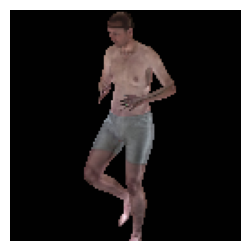

loss: 862.4605676814413


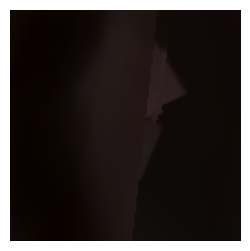

loss: 309.7852960992542


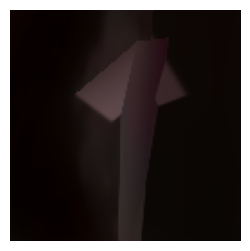

loss: 203.7833311578575


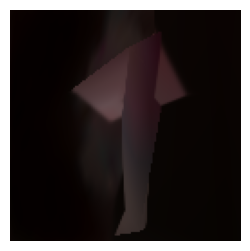

loss: 173.6508792412339


In [30]:
# training loop to learn texture and T from image
params = renderer.parameters()
optim = torch.optim.Adam(params,lr=0.01)
for i in range(1000):
    optim.zero_grad()
    images = renderer.render()
    diff = images[0,...,:3] - tgt
    loss = torch.sum(diff**2)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%300 == 0:
        plt.figure(figsize=(3,3))
        plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        plt.axis('off')
        plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


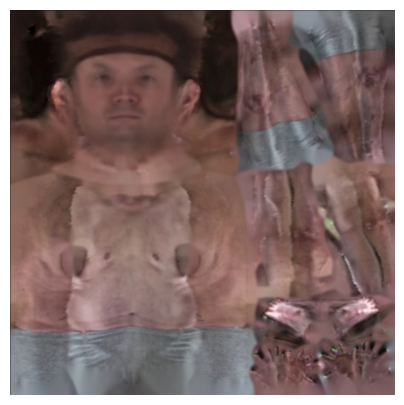

In [31]:
lazy_plot(renderer.texture_map,figsize=(5,5))

In [32]:
# save texture
# plt.imsave("data/exp/changed_texture.jpg",texture.clip(0,1))

: 